# Monte Carlo

This notebooks summarizes the Monte Carlo Reinforcement Learning algorithm, as described in David Silvers' Reinforcement Learning course. For each part the relevant theory will be introduced, followed by an implementation in Python.

We will test our implementation by following the assignment, Easy21, which can be found at: [https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf)

It covers:
* Monte-Carlo Policy Evaluation, both state and state-action (Lecture 3)
* Monte-Carlo Policy Iteration (Lecture 4)
* Model-Free control using Monte-Carlo & $\epsilon$-greedy policy improvement

Previous knowledge:
* Lectures 1 and 2

# Glossary

* MDP: Markov Decision Processes

# Implementing our environment

The assignment Easy21 describes a game similar to Blackjack. We will implement the environment of the game, which allow us to use our Monte Carlo Agent to play the game!

From the assignment: "You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state s (dealer’s first card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns a sample of the next state $s_0$ (which may be terminal if the game is finished) and reward r. We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state"

In [1]:
from collections import namedtuple
from typing import Callable, List, Tuple

import numpy as np

STICK = 0
HIT = 1
ACTION_SPACE = [
    STICK,
    HIT,
]
DEALER_HIT_MAX = 17

# min in inclusive, max is exclusive!
Range = namedtuple('Range', ['min', 'max'])
PLAYER_RANGE_FOR_ACTION = Range(1, 22)
DEALER_RANGE_FOR_ACTION = Range(1, 11)


class Easy21:
    def __init__(self):
        self.action_space = [
            STICK,
            HIT,
        ]
        self.state_max_bound = (
            DEALER_RANGE_FOR_ACTION.max,
            PLAYER_RANGE_FOR_ACTION.max,
        )

        self.state_min_bound = (
            DEALER_RANGE_FOR_ACTION.min,
            PLAYER_RANGE_FOR_ACTION.min,
        )

    def reset(self):
        """
        Reset the environment to the initial state:
        "At the start of the game both the player and the dealer draw one black
        card (fully observed)"

        :return: Observation consisting of (dealer card, player card)
        """
        return tuple(np.random.randint(low=1, high=11, size=(2,)))

    def _draw(self) -> Tuple[int, str]:
        """
        Draw a card according to easy21 rules:
        - Each draw from the deck results in a value between 1 and 10 (uniformly distributed)
          with a colour of red (probability 1/3) or black (probability 2/3).
        - There are no aces or picture (face) cards in this game
        :return: Tuple of card value and card color
        """
        card = np.random.randint(1, 11)
        color = np.random.choice(['b', 'r'], p=[2/3, 1/3])

        return card, color

    def _draw_and_update(self, prev_sum):
        """
        Draw a card from the deck and add or subtract from the current sum of the given cards
        The values of the cards are added (black cards) or subtracted (red cards)

        :param prev_sum: Previous sum of cards
        :return: New sum of cards after drawing a card from the deck
        """
        value, color = self._draw()
        value = -1*value if color == 'r' else value
        return prev_sum + value

    def step(self, s: Tuple[int, int], a: int) -> Tuple[Tuple[int, int], int, bool]:
        """
        Takes as input a state s (dealer’s first card 1–10 and the player’s sum 1–21),
        and an action a (hit or stick), and returns a sample of the next state s0
        (which may be terminal if the game is finished) and reward r

        :param s: Input state s of format (dealer’s first card 1-10, player’s sum 1–21)
        :param a: Action to perform: 0-stick or 1-hit
        :return: The next state, the reward and True/False if terminal state
        """

        dealer_card, player_sum = s

        # Player sticks
        if STICK == a:
            s1, reward, is_terminal = self._stick(dealer_card, player_sum)
        # Player hits
        elif HIT == a:
            s1, reward, is_terminal = self._hit(dealer_card, player_sum)
        else:
            raise ValueError('Unknown action value:', a)

        # Clip state to boundaries
        s1 = tuple(np.clip(s1, a_min=self.state_min_bound, a_max=self.state_max_bound))

        return s1, reward, is_terminal

    def _stick(self, dealer_card: int, player_sum: int) -> Tuple[Tuple[int, int], int, bool]:
        """
        If the player sticks then the dealer starts taking turns. The dealer always
        sticks on any sum of 17 or greater, and hits otherwise.
        If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1),
        lose (reward -1), or draw (reward 0) – is the player with the largest sum.

        :param dealer_card: The dealers' card, between 1-10
        :param player_sum: The sum of the players' cards, between 1-21
        :return: The next state, the reward and True/False if terminal state
        """

        # Dealer hits until reaching sum of 17 or greater
        dealer_sum = self._draw_and_update(dealer_card)
        while 0 < dealer_sum < DEALER_HIT_MAX:
            dealer_sum = self._draw_and_update(dealer_sum)

        # Dealer didn't go bust, winner has higher sum
        if 1 <= dealer_sum <= 21:
            if player_sum > dealer_sum:  # Player wins
                return (dealer_sum, player_sum), 1, True
            elif player_sum == dealer_sum:  # Tie
                return (dealer_sum, player_sum), 0, True
            else:  # Dealer wins!
                return (dealer_sum, player_sum), -1, True
        else:  # Dealer goes bust
            return (dealer_sum, player_sum), 1, True

    def _hit(self, dealer_card: int, player_sum: int) -> Tuple[Tuple[int, int], int, bool]:
        """
        If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)

        :param dealer_card: The dealers' card, between 1-10
        :param player_sum: The sum of the players' cards, between 1-21
        :return: The next state, the reward and True/False if terminal state
        """
        new_player_sum = self._draw_and_update(player_sum)

        # Player still not bust yet
        if 1 <= new_player_sum <= 21:
            return (dealer_card, new_player_sum), 0, False
        else:
            return (dealer_card, new_player_sum), -1, True

In addition, we will also implement a method for running a full episode in our environment. For Monte-Carlo we will need to run many full episodes, so we'll implement this once and use it for all of our Monte-Carlo implementations.

In [2]:
def episode(env, policy: Callable) -> Tuple[List[Tuple[int, int]], List[int], List[int]]:
    """
    Run an episode in the given environment using the given policy

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :return: List of the states, list of the rewards and list of the actions
    """
    s0 = env.reset()

    episode_states, rewards, actions = [], [], []

    while True:
        a = policy(s0)
        s1, reward, is_terminal = env.step(s0, a)

        episode_states.append(s0)
        rewards.append(reward)
        actions.append(a)

        if is_terminal is True:
            break

        s0 = s1

    return episode_states, rewards, actions

Let's also define a variable for how many episodes we want to run each algorithm for:

In [3]:
N_EPISODES = 100_000
rng = np.random.default_rng()
PLOT_SIZE = (7, 7)

# What is Monte-Carlo Reinforcement Learning?

* Not necessarily the most efficient, but it is effective and widely used.
* Learn directly from episodes of experience
* Model-free: no knowledge of MDP transitions / rewards
* Learns from complete episodes, no bootstrapping
* Uses the simple idea that `value = mean return`
* Only episodic MDPs, all episodes must terminate

# Monte-Carlo Policy Evaluation

* Goal: learn $v_π$ from episodes of experience under policy $π$
$$S_1, A_1, R_2, ..., S_k ∼ π$$
* Recall that the return is the total discounted reward ($\gamma$ is discount factor):
$$G_t = R_{t+1} + γR_{t+2} + ... + γ^{T−1}R_T$$
- Recall that the value function is the expected return:
$$v_π(s) = E_π[G_t | S_t = s]$$
- Monte-Carlo policy evaluation uses empirical mean return instead of expected return
* Robot example:
	* Let it talk a walk, and calculate the reward observed from the walk
	* Each walk is an episode
	* $v_\pi=\mathbb{E}[All walks]$


# Monote-Carlo State Policy Evaluation

## First Visit Monte-Carlo Policy Evaluation
Basically, we sample trajectories using our policy. Each trajectory is an episode. For the state we take the average of the rewards from the state of all episodes the state was a part of.
So $N(s)$ is the counter of how many times we saw this state, as we increment it once each episode. $S(s)$ is the cumulative rewards observed for state $s$. We add $G_t$ as this way we take the value seen at the given state at time $t$. The law of large numbers simply tells us that if we have enough samples of values for each state, the mean will be correct as the variance will be low ($1/n$ where $n$ is the number of episodes, so not dependent on our environment size, but on the amount of times seen our state, so no longer effected by huge MDPs! We see only the states the our policy $\pi$ cares about, and enough sampling makes sure we evaluate all the states the policy is interested in)

- To evaluate state $s$
- The first time-step t that state s is visited in an episode
	- Increment counter $N(s) ← N(s) + 1$
	- Increment total return $S(s) ← S(s) + G_t$
- Value is estimated by mean return $V(s) = S(s)/N(s)$
- By law of large numbers, $V(s) → v_π(s)$ as $N(s) → ∞$

We will now implement this!

In [4]:
from typing import Callable
import numpy as np

def first_visit_mc_policy_eval(env, policy: Callable, n_episodes: int) -> np.ndarray:
    """
    Run First Visit Monte Carlo Policy Evaluation.
    Given an environment and policy, evaluate the policy by running episodes
    and calculating the mean reward per state.
    First visit only takes into account the first visit to each state per episode.

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :param n_episodes: Number of episodes to run
    :return: Numpy array representing the value function of the policy
    """

    # Initialize N, S
    N = np.zeros(shape=(11, 22))
    S = np.zeros(shape=(11, 22))

    # Run episodes
    all_episodes = [episode(env=env, policy=policy) for j in range(n_episodes)]

    for states, rewards, actions in all_episodes:
        visited_states = []
        G = 0
        for i in range(len(states)-1, -1, -1):
            dealer, player = states[i]
            G += rewards[i]
            if (dealer, player) not in visited_states:
                N[dealer, player] += 1
                S[dealer, player] += G
            visited_states.append((dealer, player))

    # As N will be 0 for states we didn't visit, we use np.errstate to make `x/0=np.nan` and then convert all nan to 0
    # As described in https://stackoverflow.com/questions/26248654/how-to-return-0-with-divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        V = S / N
        V = np.nan_to_num(V)

    return V

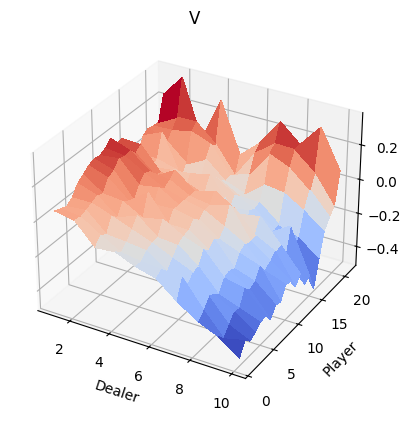

In [5]:
from src.helpers import plot_value_function

env = Easy21()
random_policy = lambda state: np.random.choice(env.action_space)
V = first_visit_mc_policy_eval(env=env, policy=random_policy, n_episodes=N_EPISODES)

plot_value_function(V, state_action_value_function=False)

## Every Visit Monte-Carlo Policy Evaluation
Just like First Visit Monte-Carlo Policy Evaluation, but we increment $N(s)$ every time we enter the state.

In [6]:
def every_visit_mc_policy_eval(env, policy, n_episodes):
    """
    Run Every Visit Monte Carlo Policy Evaluation.
    Given an environment and policy, evaluate the policy by running episodes
    and calculating the mean reward per state.
    Every visit takes into account all visits to each state.

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :param n_episodes: Number of episodes to run
    :return: Numpy array representing the value function of the policy
    """
    # Initialize N, S
    N = np.zeros(shape=(11, 22))
    S = np.zeros(shape=(11, 22))

    all_episodes = [episode(env=env, policy=policy) for j in range(n_episodes)]

    for states, rewards, actions in all_episodes:
        G = 0
        for i in range(len(states)-1, -1, -1):
            dealer, player = states[i]
            G += rewards[i]
            N[dealer, player] += 1
            S[dealer, player] += G

    with np.errstate(divide='ignore', invalid='ignore'):
        V = S / N
        V = np.nan_to_num(V)

    return V


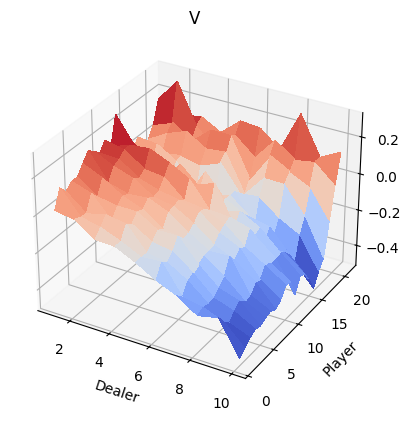

In [7]:
from src.helpers import plot_value_function

env = Easy21()
random_policy = lambda state: np.random.choice(env.action_space)
V = every_visit_mc_policy_eval(env=env, policy=random_policy, n_episodes=N_EPISODES)

plot_value_function(V, state_action_value_function=False)

## Incremental Monte-Carlo Updates
- Perform Monte-Carlo updates to $V(s)$ incrementally after the episode
- For each state $S_t$ with return $G_t$
	- $N(S_t) ← N(S_t) + 1$
	- $V(S_t) = V(S_t) + \frac{1}{N(S_t)}(G_t - V(S_t))$
- In non-stationary problems, it can be useful to track a running mean, i.e forget old episodes:
$$
V(S_t) \leftarrow V(S_t) + \alpha(G_t - V(S_t))
$$
- In this new form, $V(S_t)$ is a guesstimate of the value function for the state, and $(G_t - V(S_t))$ is the correction to fix the error. $\alpha$ allows weighting the error corrections, so we can over or under correct.

In [8]:
def incremental_mc_policy_eval(env, policy, n_episodes):
    """
    Run Incremental Monte Carlo Policy Evaluation.
    Given an environment and policy, evaluate the policy by running episodes
    and calculating the mean reward per state.
    Incremental MC uses the incremental mean equation to perform updates to the mean incrementally after each episode.

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :param n_episodes: Number of episodes to run
    :return: Numpy array representing the value function of the policy
    """
    N = np.zeros(shape=(11, 22))
    V = np.zeros(shape=(11, 22))

    # Run episodes
    for j in range(n_episodes):
        states, rewards, actions = episode(env=env, policy=policy)
        G = 0
        # Update value function for each state visited in this episode
        for i in range(len(states)-1, -1, -1):
            dealer, player = states[i]
            G += rewards[i]
            idx = dealer, player

            N[idx] += 1
            alpha = 1 / N[idx]
            V[idx] = V[idx] + alpha * (G - V[idx])

    return V

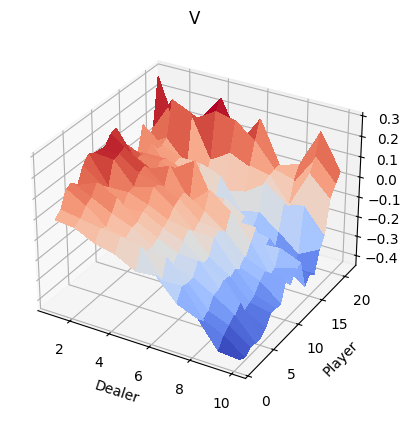

In [9]:
from src.helpers import plot_value_function

env = Easy21()
random_policy = lambda state: np.random.choice(env.action_space)
V = incremental_mc_policy_eval(env=env, policy=random_policy, n_episodes=N_EPISODES)

plot_value_function(V, state_action_value_function=False)

# Monte-Carlo Action State Policy Evaluation

Now we know how to take a policy and evaluate it! To improve the policy, we could greedily improve our policy using the new values we found.

The major issue with this is that we need to have full observability for this. To solve this issue, we can tweak our methods to take account for states **and actions.** This change will allow us to create a greedy improvement methodology, where for each state we take the step which maximizes reward.

This is model free! We don't need any knowledge of the full MDP and we improve we visit each state.

Formally, we learn an action-state value function $Q(s, a)$ and our greedy policy is $\pi'(s)=\underset{a'∈A}{argmax}Q(s,a)$

## First Visit Monte-Carlo Policy Evaluation

In [10]:
def first_visit_mc_policy_eval(env, policy, n_episodes):
    """
    Run First Visit Monte Carlo Policy Evaluation.
    Given an environment and policy, evaluate the policy by running episodes
    and calculating the mean reward per state.
    First visit only takes into account the first visit to each state per episode.

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :param n_episodes: Number of episodes to run
    :return: Numpy array representing the value function of the policy
    """
    N = np.zeros(shape=(11, 22, 2))
    S = np.zeros(shape=(11, 22, 2))

    all_episodes = [episode(env=env, policy=policy) for j in range(n_episodes)]

    for states, rewards, actions in all_episodes:
        visited_states = []
        G = 0
        for i in range(len(states)-1, -1, -1):
            dealer, player = states[i]
            G += rewards[i]
            if (dealer, player) not in visited_states:
                N[dealer, player, actions[i]] += 1
                S[dealer, player, actions[i]] += G
                visited_states.append((dealer, player))

    with np.errstate(divide='ignore', invalid='ignore'):
        V = S / N
        V = np.nan_to_num(V)

    return V

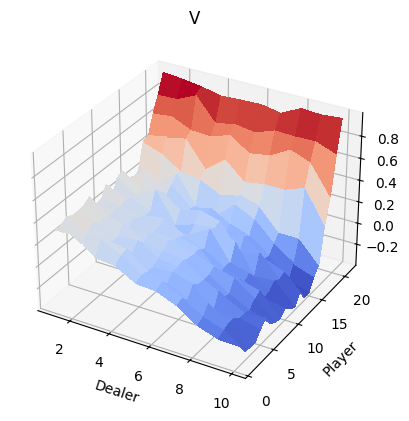

In [11]:
from src.helpers import plot_value_function

env = Easy21()
random_policy = lambda state: np.random.choice(env.action_space)
V = first_visit_mc_policy_eval(env=env, policy=random_policy, n_episodes=N_EPISODES)

plot_value_function(V, state_action_value_function=True)

## Every Visit Monte-Carlo Policy Evaluation

In [12]:
def every_visit_mc_policy_eval(env, policy, n_episodes):
    """
    Run Every Visit Monte Carlo Policy Evaluation.
    Given an environment and policy, evaluate the policy by running episodes
    and calculating the mean reward per state.
    Every visit takes into account all visits to each state.

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :param n_episodes: Number of episodes to run
    :return: Numpy array representing the value function of the policy
    """
    N = np.zeros(shape=(11, 22, 2))
    S = np.zeros(shape=(11, 22, 2))

    all_episodes = [episode(env=env, policy=policy) for j in range(n_episodes)]

    for states, rewards, actions in all_episodes:
        G = 0
        for i in range(len(states)-1, -1, -1):
            dealer, player = states[i]
            G += rewards[i]
            N[dealer, player, actions[i]] += 1
            S[dealer, player, actions[i]] += G

    with np.errstate(divide='ignore', invalid='ignore'):
        V = S / N
        V = np.nan_to_num(V)

    return V

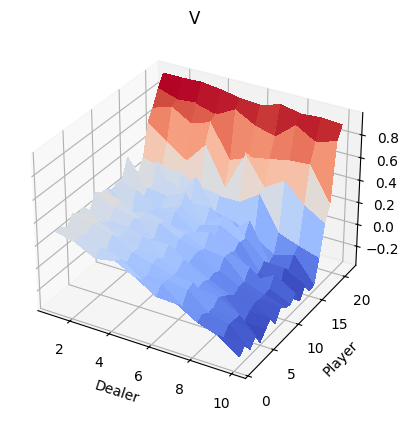

In [13]:
from src.helpers import plot_value_function

env = Easy21()
random_policy = lambda state: np.random.choice(env.action_space)
V = every_visit_mc_policy_eval(env=env, policy=random_policy, n_episodes=N_EPISODES)

plot_value_function(V, state_action_value_function=True)

## Incremental Monte-Carlo Updates

In [14]:
def incremental_mc_policy_eval(env, policy, n_episodes):
    """
    Run Incremental Monte Carlo Policy Evaluation.
    Given an environment and policy, evaluate the policy by running episodes
    and calculating the mean reward per state.
    Incremental MC uses the incremental mean equation to perform updates to the mean incrementally after each episode.

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :param n_episodes: Number of episodes to run
    :return: Numpy array representing the value function of the policy
    """
    N = np.zeros(shape=(11, 22, 2))
    V = np.zeros(shape=(11, 22, 2))


    # Run episodes
    for j in range(n_episodes):
        states, rewards, actions = episode(env=env, policy=policy)
        G = 0
        # Update value function for each state visited in this episode
        for i in range(len(states)-1, -1, -1):
            dealer, player = states[i]
            G += rewards[i]
            idx = dealer, player, actions[i]

            N[idx] += 1
            alpha = 1 / N[idx]
            V[idx] = V[idx] + alpha * (G - V[idx])

    return V


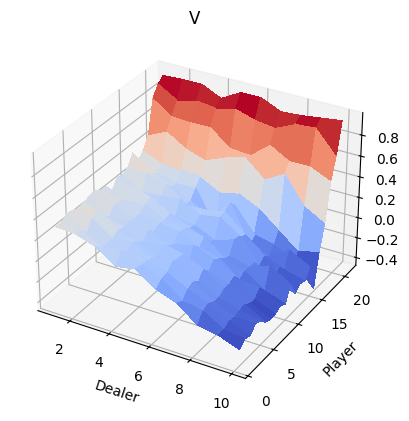

In [15]:
from src.helpers import plot_value_function

env = Easy21()
random_policy = lambda state: np.random.choice(env.action_space)
V = incremental_mc_policy_eval(env=env, policy=random_policy, n_episodes=N_EPISODES)

plot_value_function(V, state_action_value_function=True)

# Monte Carlo Control

We will now finally implement Monte-Carlo control, finally allowing us to learn the optimal policy for Easy21.

## $\epsilon$-greedy exploration
Before that, we need to discuss the exploration issue. By sampling trajectories and then choosing one greedily, we could be contained to a specific part of the space. We don't explore new places which could result in better values in the long run!

To solve this issue, we can use $\epsilon$-greedy exploration. It's simple, but works incredibly well! Basically you flip a coin with $\epsilon$ probability to choose to explore, or take the greedy choice. Formally:

> - All $m$ actions are tried with non-zero probability
> - With probability $1-\epsilon$ choose the greedy action
> - With probability $\epsilon$ choose an action at random
$$
\begin{equation}
\pi(a|s) =
\begin{cases}
  \frac{\epsilon}{m} + 1 - \epsilon, & \text{if }
       a^∗ = \underset{a \in A}{\text{argmax }}Q(s, a)
\\
  \frac{\epsilon}{m}, & \text{otherwise}
\end{cases}
\end{equation}
$$

In [16]:
def epsilon_greedy_policy(state, N, Q, N_0=100):
    """
    Policy which allows for exploration and exploitation.
    Flip a coin with epsilon probability to choose to explore, or take the greedy choice
    If taking the greedy choice, we take the argmax[Q(s, a)] for all actions
    If the actions have equal values, we flip a fair coin

    :param state: State tuple of (dealer card, player card)
    :param N: Table of count of visits per state
    :param Q: Table of total reward per state and action
    :param N_0: Constant for epsilon decay
    :return: Action to perform
    """

    # Exploration with probability epsilon
    epsilon = N_0 / (N_0 + N[state].sum())
    if rng.choice([True, False], p=[epsilon, 1.0 - epsilon]):
        return rng.choice(ACTION_SPACE)

    # If not exploring, use greedy(Q)
    # Special case if both actions have same value, argmax takes first, we want random
    arr = Q[state]
    if np.all(arr == arr.max()):
        return rng.choice(ACTION_SPACE)

    return np.argmax(arr)

## Monte-Carlo control code
We will initialize our value function $Q(s, a)=0$ for all states and actions. Then we iteratively evaluate our policy and greedily improve it!

In [17]:
from functools import partial

def monte_carlo_control(env, policy, n_episodes):
    """
    Run Monte Carlo Control on environment using the given policy.
    Will perform iterative steps of policy evaluation and policy improvement based on evaluation results.

    :param env: Environment to run in, should have step and reset methods
    :param policy: Policy function, which given a state returns the action to perform
    :param n_episodes: Number of episodes to run
    :return: Numpy array representing the optimal state-action value function Q*
    """
    N = np.zeros(shape=(11, 22, 2))
    Q = np.zeros(shape=(11, 22, 2))

    policy = partial(policy, N=N, Q=Q)

    for _ in range(n_episodes):

        # Run episode
        states, rewards, actions = episode(env=env, policy=policy)
        G = 0

        # Update state-action value function for each state-value pair visited in this episode
        for idx in range(len(states)-1, -1, -1):
            G += rewards[idx]
            s_a = (*states[idx], actions[idx])

            N[s_a] += 1.0
            alpha = 1.0 / N[s_a]
            error = G - Q[s_a]
            Q[s_a] = Q[s_a] + alpha * error#(G - Q[s_a])

    return Q

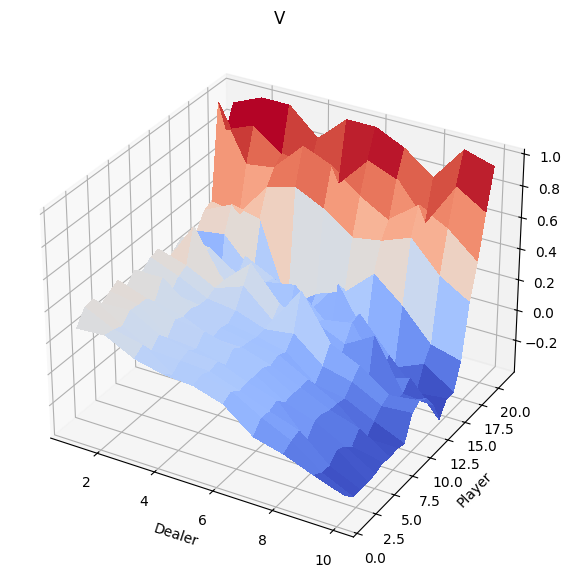

In [18]:
env = Easy21()
Q = monte_carlo_control(env=env, policy=epsilon_greedy_policy, n_episodes=100_000)

plot_value_function(Q, state_action_value_function=True, figsize=PLOT_SIZE)

## Agent

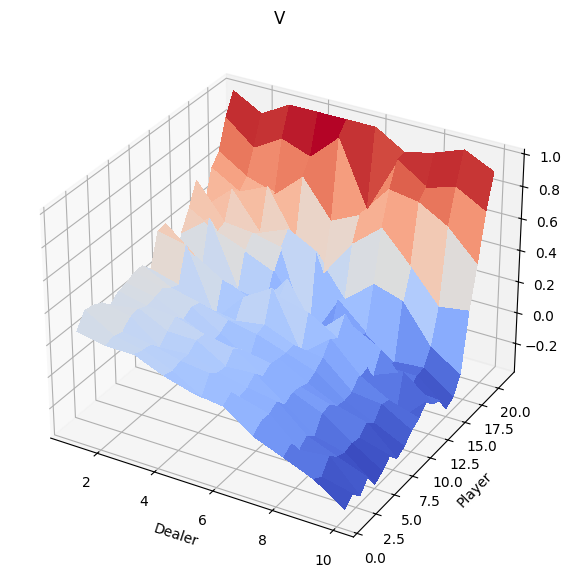

In [19]:
from src.mc_agent import MonteCarloAgent

env = Easy21()
mc = MonteCarloAgent(env=env)
mc.learn(n_episodes=N_EPISODES)
plot_value_function(mc.Q, state_action_value_function=True, figsize=PLOT_SIZE)

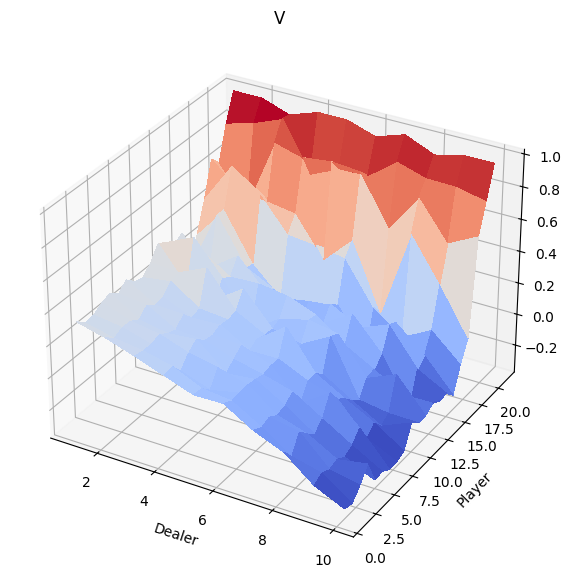

In [20]:
from src.td_agent import SARSAAgent

env = Easy21()
sarsa = SARSAAgent(env = env, lambda_=1.0)
sarsa.learn(n_episodes=N_EPISODES)
plot_value_function(sarsa.Q, state_action_value_function=True, figsize=PLOT_SIZE)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'V* action=1')

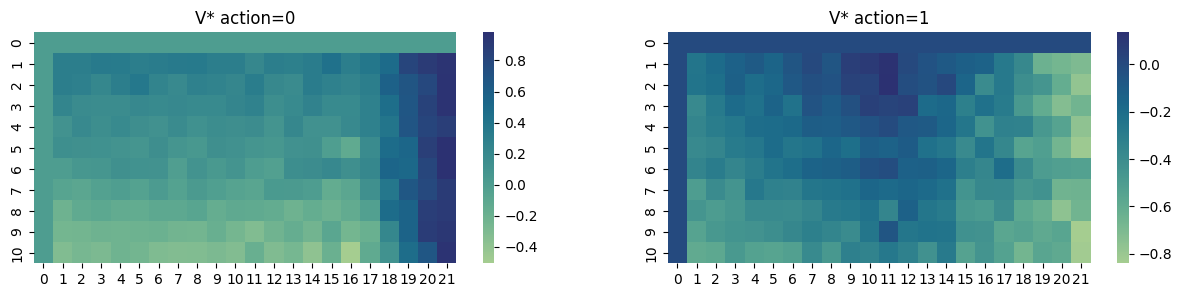

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
sns.heatmap(V[:, :, 0], ax=ax1, cmap="crest")
ax1.set_title('V* action=0')
sns.heatmap(V[:, :, 1], ax=ax2, cmap="crest")
ax2.set_title('V* action=1')

Text(0.5, 1.0, 'Q* action=1')

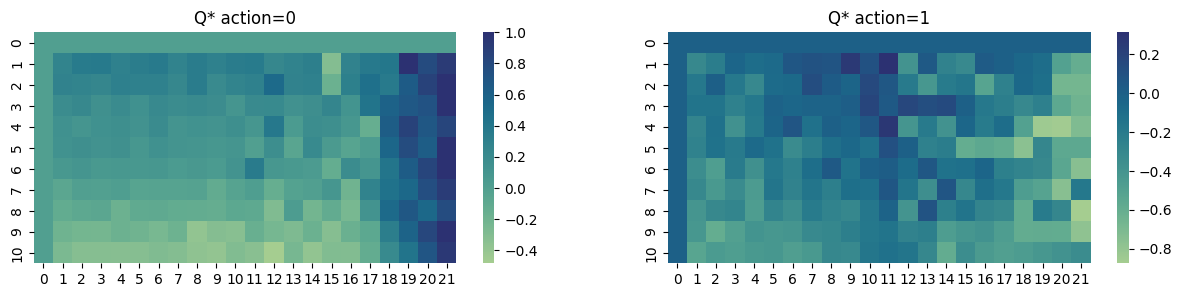

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
sns.heatmap(Q[:, :, 0], ax=ax1, cmap="crest")
ax1.set_title('Q* action=0')
sns.heatmap(Q[:, :, 1], ax=ax2, cmap="crest")
ax2.set_title('Q* action=1')

In [55]:
np.allclose(V,Q, atol=0.1)

False

In [56]:
Q[(2,3)], V[(2,3)]

(array([ 0.25219298, -0.18032787]), array([ 0.22256098, -0.12322275]))

Text(0.5, 1.0, 'Q-V action=1')

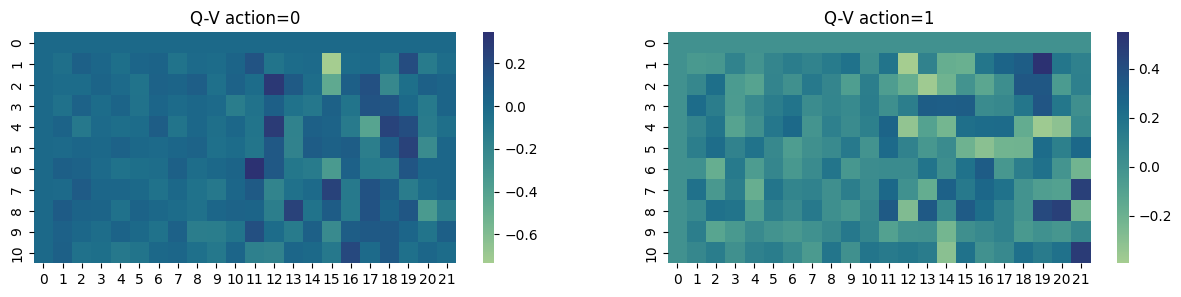

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
sns.heatmap((Q-V)[:, :, 0], ax=ax1, cmap="crest")
ax1.set_title('Q-V action=0')
sns.heatmap((Q-V)[:, :, 1], ax=ax2, cmap="crest")
ax2.set_title('Q-V action=1')

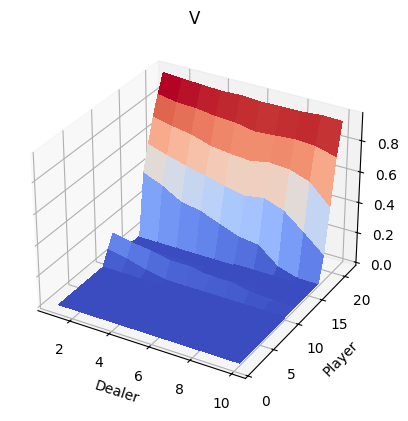

In [61]:
from src.helpers import plot_value_function

env = Easy21()
dealer_policy = lambda state: 1 if state[1] < 17 else 0
V1 = incremental_mc_policy_eval(env=env, policy=dealer_policy, n_episodes=1_000_000)

plot_value_function(V1, state_action_value_function=True)

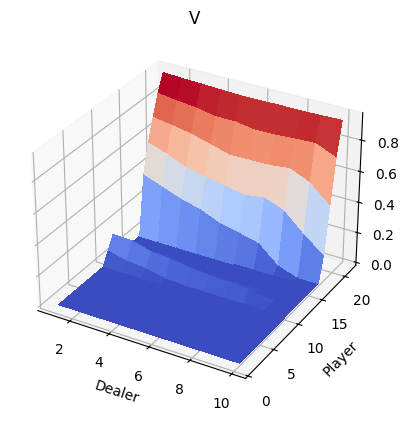

In [62]:
from src.helpers import plot_value_function

env = Easy21()
dealer_policy = lambda state: 1 if 0 < state[1] < 17 else 0
V1 = incremental_mc_policy_eval(env=env, policy=dealer_policy, n_episodes=1_000_000)

plot_value_function(V1, state_action_value_function=True)